<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Forecasting_Fbprophet_%2B_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

In [3]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II (1).xlsx


In [4]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name = ["Year 2019-2020", "Year 2020-2021"]) #reading the excel file

In [7]:
df1 = df["Year 2019-2020"]
df2 = df["Year 2020-2021"]

In [8]:
df = df1.append(df2) #combining the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Brand
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085.0,United Kingdom,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085.0,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085.0,United Kingdom,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085.0,United Kingdom,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085.0,United Kingdom,2


In [9]:
df['Country'].value_counts()

United Kingdom          981330
EIRE                     17866
Germany                  17624
France                   14330
Netherlands               5140
Spain                     3811
Switzerland               3189
Belgium                   3123
Portugal                  2620
Australia                 1913
Channel Islands           1664
Italy                     1534
Norway                    1455
Sweden                    1364
Cyprus                    1176
Finland                   1049
Austria                    938
Denmark                    817
Unspecified                756
Greece                     663
Japan                      582
Poland                     535
USA                        535
United Arab Emirates       500
Israel                     371
Hong Kong                  364
Singapore                  346
Malta                      299
Iceland                    253
Canada                     228
Lithuania                  189
RSA                        169
Bahrain 

In [30]:
data_UK = df[df['Country'] == 'United Kingdom']
data_UK['total_price'] = data_UK['Quantity'] * data_UK['Price']
data_UK['InvoiceDate'] = pd.to_datetime(data_UK['InvoiceDate'])
data_UK['InvoiceDate_15m'] = data_UK['InvoiceDate'].dt.round('15min')
data_UK['InvoiceDate_1h'] = data_UK['InvoiceDate'].dt.round('1h')

In [31]:
data_UK.isna().sum()

Invoice                 0
StockCode               0
Description          4382
Quantity                0
InvoiceDate             0
Price                   0
CustomerID         240029
Country                 0
Brand                   0
total_price             0
InvoiceDate_15m         0
InvoiceDate_1h          0
dtype: int64

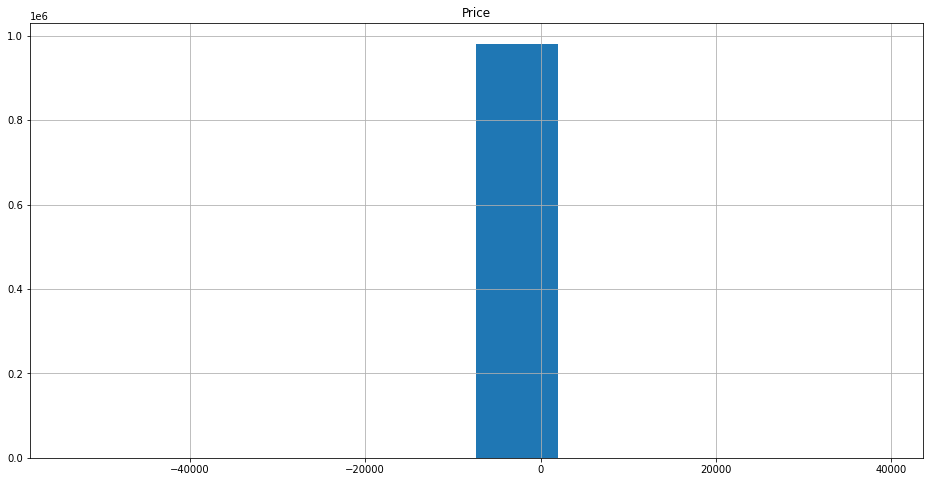

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('Price', ax=ax);

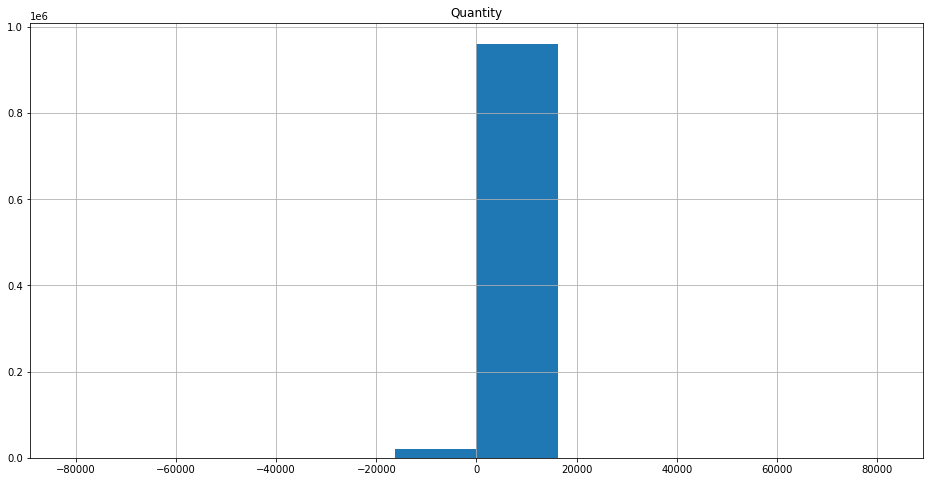

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('Quantity', ax=ax);

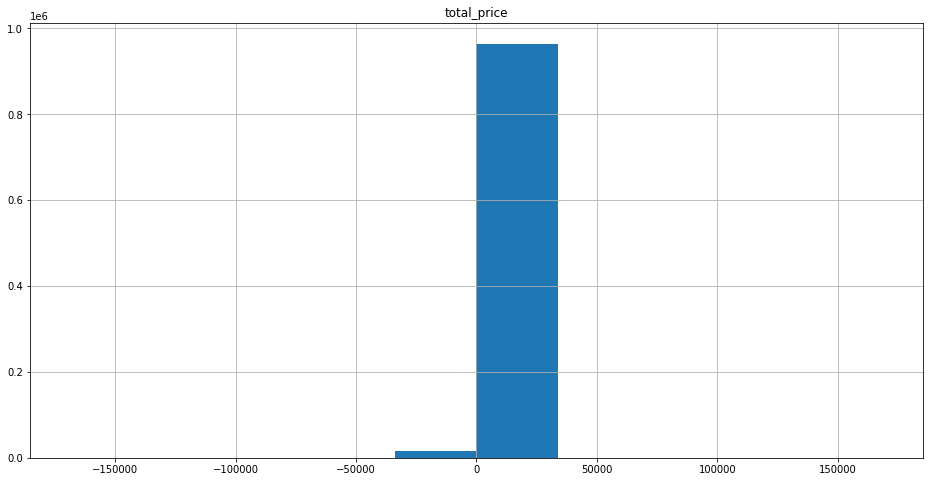

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.hist('total_price', ax=ax);

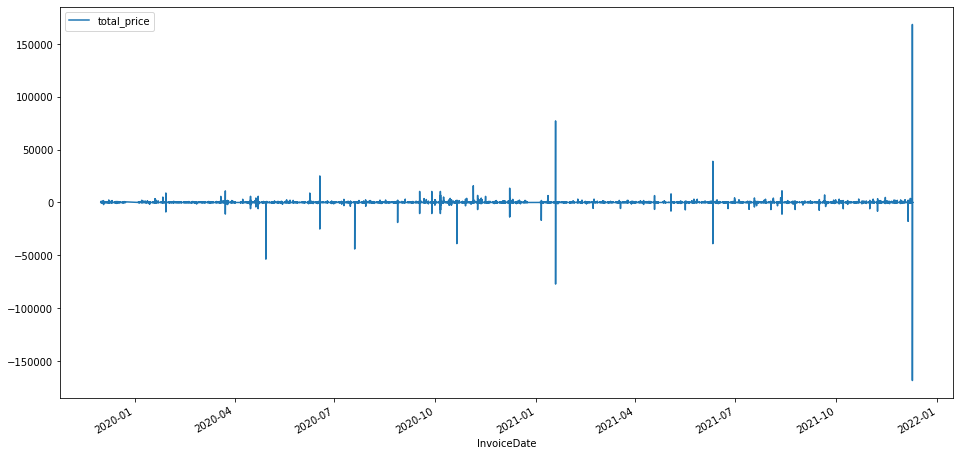

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

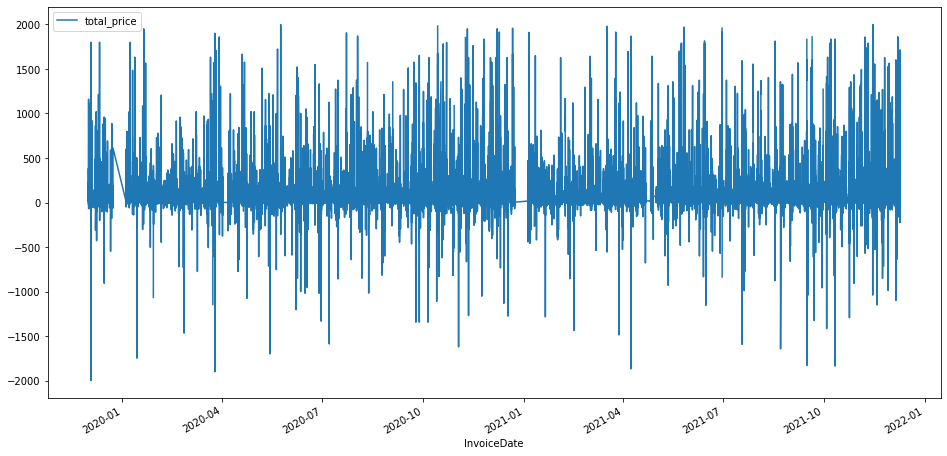

In [36]:
#data_UK = data_UK[(data_UK['total_price'] < 25000) & (data_UK['total_price'] > -25000)]
data_UK.loc[(data_UK['total_price'] > 2000) | (data_UK['total_price'] < -2000), 'total_price'] = None
fig, ax = plt.subplots(figsize=(16, 8))
data_UK.plot(x='InvoiceDate', y='total_price', ax=ax);

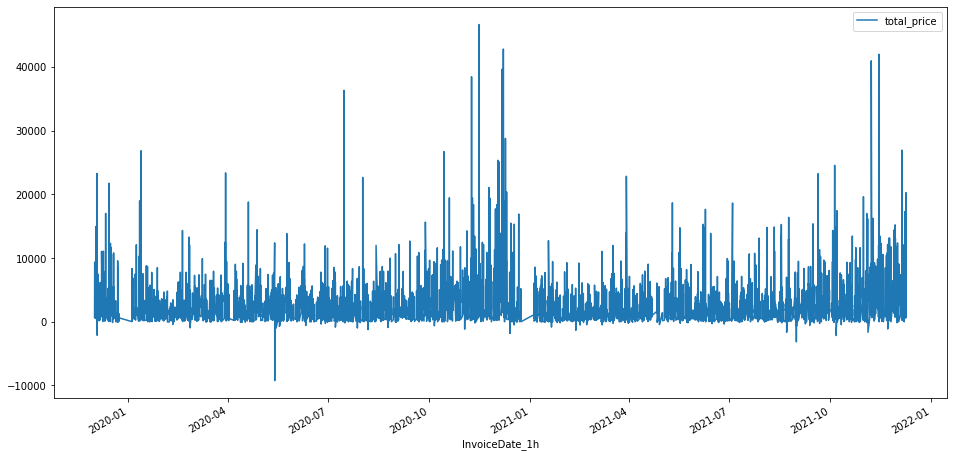

In [37]:
data_UK_1h = data_UK.groupby('InvoiceDate_1h').agg({'total_price':'sum'})
fig, ax = plt.subplots(figsize=(16, 8))
data_UK_1h.plot(y='total_price', ax=ax);

In [38]:
t = np.arange(data_UK_1h.index[0], data_UK_1h.index[-1] + timedelta(hours=1), timedelta(hours=1)).astype(datetime)
train_test = pd.DataFrame()
train_test['ds'] = pd.to_datetime(t)
train_test['y'] = 0
train_test['cap'] = 20000
train_test['floor'] = -2000
train_test.iloc[train_test['ds'].isin(data_UK_1h.index), 1] = data_UK_1h['total_price']
train_test.shape

(17742, 4)

**Hyperparameter Tuning with Optuna**

In [39]:
!pip install optuna

In [40]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


test_size = int(train_test.shape[0] / 10)
train_df = train_test.iloc[:-test_size, :]
val_df = train_test.iloc[-test_size:int(-test_size/2), :]
test_df = train_test.iloc[int(-test_size/2):, :]

In [41]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train_df)
    preds = m.predict(val_df[['ds', 'cap', 'floor']])
    
    mae_score = mean_absolute_error(val_df['y'], preds['yhat'])
    return mae_score

In [42]:
params = {
     'changepoint_prior_scale': 3.391667952710346,
     'changepoint_range': 0.8397114666270911,
     'seasonality_prior_scale': 3.6115808925351867,
     'holidays_prior_scale': 4.845991897188627,
     'seasonality_mode': 'multiplicative',
     'growth': 'linear',
     'weekly_seasonality': 10,
     'yearly_seasonality': 3
}


**Scores of Fbprophet**

In [43]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)
    
    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }
    
    return report_dict

In [44]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')

concat_train_df = pd.concat([train_df, val_df])
m.fit(concat_train_df)
preds = m.predict(test_df[['ds', 'cap', 'floor']])
result = regression_report(test_df['y'], preds['yhat'])

In [45]:
result

{'mae_score': 1247.0798344899308,
 'mse_score': 9178065.10373162,
 'r2_score': 0.36966130404977093}

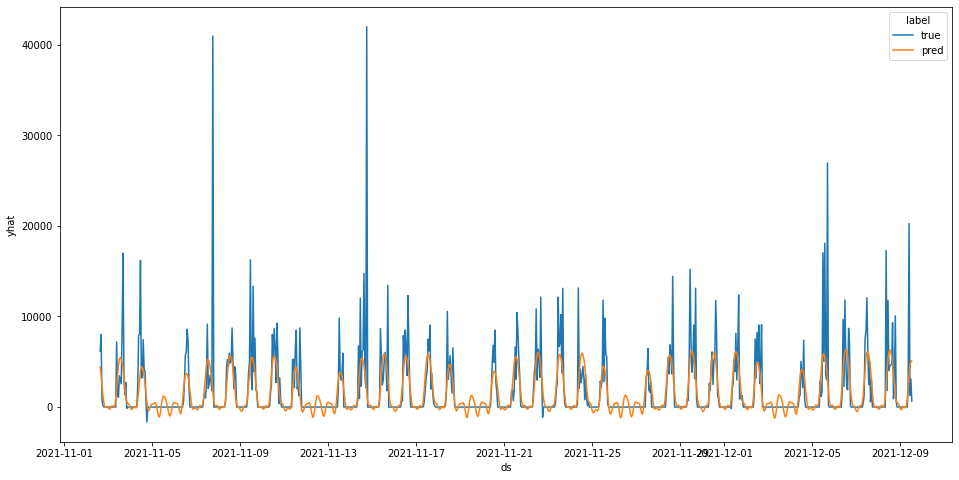

In [46]:
pd.options.mode.chained_assignment = None
test_df.loc[:, 'label'] = 'true'
test_df.loc[:, 'yhat'] = test_df.loc[:, 'y']
preds.loc[:, 'label'] = 'pred'
df_result = pd.concat([test_df[['yhat', 'label', 'ds']], preds[['yhat', 'label', 'ds']]])
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(y='yhat', x='ds', ax=ax, data=df_result, hue='label', markers=True)
plt.show()